In [1]:
# The purpose of this algorithm is to assign seats to maximize social distancing for highest priority passengers
# and limit air travel for unnecessary purposes
import random
import scipy as sci
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline

import uuid

In [2]:
# use information based on Model of airplane, for economy seating

# 1. Boeing 787 
#    - rows in economy : 17 
#    - columns: 3
#    - seats per col (spc): 3-3-3  # ABC DEF GHJ

    
# 2. Boeing 737
#    - rows in economy : 18
#    - columns: 2
#    - seats per col: 3-3 # ABC DEF

# 3. Airbus 380
#    - rows in economy : 43
#    - columns: 3
#    - seats per col: 3-4-3 # ABC DEFG HJK


# create global lookup for airplane models
airplane_dictionary = {
        'Boeing_787': {'start_row': 14, 'rows': 17, 'columns': 3, 'seat_letters': ['A', 'B', 'C', ' ', 'D', 'E', 'F', ' ', 'G', 'H', 'J']},
        'Boeing_737': {'start_row': 8, 'rows': 18, 'columns': 2, 'seat_letters': ['A', 'B', 'C', ' ', 'D', 'E', 'F']},
        'Airbus_380': {'start_row': 43, 'rows': 40, 'columns': 3, 'seat_letters': ['A', 'B', 'C', ' ', 'D', 'E', 'F', 'G', ' ', 'H', 'J', 'K']}}

# global character str for aisle visual
aisle = '| |'

# global default offset for social distancing
default_offset = {'x': 0, 'y': 0, 'method': 'cardinal_only'}

In [3]:
# Create Airplane Class Object

class Airplane:

    def __init__(self, model):
        self.model = model
        self.start_row = airplane_dictionary[model]['start_row']
        self.rows = airplane_dictionary[model]['rows']
        self.columns = airplane_dictionary[model]['columns']
        self.seat_letters = airplane_dictionary[model]['seat_letters']

    # Create: 
    
    def create_cabin(self):
        df_rows = list(range(self.start_row, (self.start_row + self.rows + 1)))
        df_cols = self.seat_letters
        cabin = pd.DataFrame(index=df_rows, columns=df_cols).fillna(0)
        
        # create columns with ' ' to visualize open aisles
        for col in cabin.columns:
            if col == ' ':
                cabin[col] = aisle
        
        # assign the initialized pandas dataframe to the Airplane attribute self.cabin
        self.cabin = cabin
        
        # randomly assign plane capacity, setting a threshold at 15%
        min_threshold = 0.25 
        capacity = max(min_threshold, random.random())
        self.capacity = round(capacity,3)
        
        # each cell of DataFrame for open seat has a state set to int(0)
        # summing all 0's will provide an available seat count
        self.total_seats = ((self.cabin == 0).sum(axis=1)).sum(axis=0)
        
        # remaining seats will be the # of passengers on this flight based on the booked capacity (random)
        self.booked_seats = int(self.total_seats*capacity)
        self.remaining_seats_to_assign = self.booked_seats
        
        # the buffer is the count of seats devoted to social distancing 
        self.buffer_seats = 0
        
        # available seats are non-buffer, and are vacant for passengers
        self.free_seats = self.total_seats - self.booked_seats
        
        # Seat Names will appear like: '35C' for the ticket assigned seat
        # self.next_seat acts as a "cursor" to the airplane
        # we initialize the cursor at the last row number and first seat column letter
        self.next_seat = str(max(df_rows)) + str(df_cols[0])  
        
        # the last assigned seat will be tracked as the last seat that had the state 
        # toggled from int(0) or int(1) to 'P', the self.first_skip will be set to None
        self.last_assigned_seat = None
        self.first_skip = None
        
        # open row counter will allow us to easily assign open rows if capacity of the flight is low enough
        self.open_rows = self.columns * self.rows
        
        # create the prioritized columns list based on airplane model and available seat selection
        self.priority_seat_order = self.prioritize_columns()
    
    # Read: 
    
    def view_plane(self, pretty=True, details=True):
        if details:
            self.details()
            
        if pretty:
            pretty_cabin = self.cabin.copy()
            for row in pretty_cabin.index:
                for col in pretty_cabin.columns:
                    if isinstance(pretty_cabin.loc[row, col], list):
                        pretty_cabin.loc[row, col] = '+'
                    else:
                        pass
                        
            print(pretty_cabin)
            
        else:
            print(self.cabin, '\n')
    
    # Update - look at seat details: 
    
    def update(self):        
        self.remaining_seats_to_assign = self.booked_seats\
                                        - ((self.cabin == 'P').sum(axis=1)).sum(axis=0)\
                                        - ((self.cabin == 'G').sum(axis=1)).sum(axis=0)
        
        self.buffer_seats = self.total_seats\
                            - ((self.cabin == 1).sum(axis=1)).sum(axis=0)\
                            - ((self.cabin == 0).sum(axis=1)).sum(axis=0)\
                            - ((self.cabin == 'P').sum(axis=1)).sum(axis=0)\
                            - ((self.cabin == 'G').sum(axis=1)).sum(axis=0)
    
        self.free_seats = self.total_seats - self.booked_seats - self.buffer_seats 
        assert self.free_seats >= 0, "Buffer Overflow!"
    
    
    def details(self):
        # Get Stats on Plane
        print("Total Seats: {}".format(self.total_seats))
        print("Capacity: {}%".format(round(self.capacity*100, 3)))
        print("Booked Seats: {}".format(self.booked_seats))     
        print("Remaining Seats to Assign: {}".format(self.remaining_seats_to_assign))
        print("Buffer Seats: {}".format(self.buffer_seats))
        print("Free Seats: {}".format(self.free_seats))

#         self.count_open_rows()
#         print("Total Open Rows: {}".format(self.open_rows))
        
        print("Last Assigned Seat: {}".format(self.last_assigned_seat))
        print("Next Seat to Assign: {}".format(self.next_seat))
        print("\n")
        

    # Delete - Clear out plane with new initialized DataFrame
    def deplane(self):
        self.next_seat = str(self.start_row + self.rows) + str(self.seat_letters[0])
        plane_index = list(range(self.start_row, self.start_row+self.rows+1))
        self.cabin = pd.DataFrame(index=plane_index, columns=self.seat_letters).fillna(0)
        for col in self.seat_letters:
            if col == ' ':
                self.cabin[col] = aisle
        
        self.last_assigned_seat = None
        self.remaining_seats_to_assign = self.booked_seats
        self.free_seats = self.total_seats - self.booked_seats
        self.buffer_seats = 0
        self.find_open_seat()

        
        
    def __del__(self):
        print("Restart Plane")
        print('\n')

###################################################################################################


    def prioritize_columns(self):
        seat_columns = self.seat_letters[:]
        search_priority_list = list()
                
        # possible use "this" row as a way to switch window/aisle alternating priority
        this_row = int(self.next_seat[:-1])
        
        # start with windows
        search_priority_list.append(seat_columns[0])
        search_priority_list.append(seat_columns[(len(seat_columns)-1)])
        

        # then add in aisle seats

        for i in range(1, len(seat_columns)-1):
            check_col = seat_columns[i]
            next_col = seat_columns[i+1]
            prev_col = seat_columns[i-1]
            
            if next_col == ' ' or prev_col == ' ':
                search_priority_list.append(check_col)

        # this should add all aisle seats, now fill in middle seats in order

        for i in range(1, len(seat_columns)-1):
            col = seat_columns[i]
            if col not in search_priority_list:
                search_priority_list.append(col)
            
        
        search_priority_list.remove(' ')
        return search_priority_list
                              
###################################################################################################                


    def find_open_seat(self):
        # Open Seat is defined as int(0) Seat State
        # *EDIT: this function no longer is recursive
        #        too easily stuck in while loops from testing phase
        
        self.last_assigned_seat = self.next_seat

        search_for_state = int(0)
        skip_seat_state = int(1)
        
#         # update self.next_seat to back of plane if any are open
#         original_seat = self.next_seat
        
        # search for open seats in the priority order (window, aisle, then middle)
        search_cols = self.priority_seat_order
                
        # start from bottom row
        check_row = self.start_row + self.rows
        seat_state = -1
        
        while seat_state != search_for_state and check_row >= self.start_row:
            # check left to right with for loop
            for i in range(0, len(search_cols)):
                check_col = search_cols[i]
                seat_state = self.cabin.loc[check_row, check_col]
                
                if seat_state == search_for_state:
                    next_col = check_col
                    next_row = check_row
                    self.next_seat = str(next_row) + next_col
                    break  
                elif seat_state == skip_seat_state and self.first_skip != None:
                    self.first_skip = str(check_row) + check_col
                else:
                    pass
                    
            
            check_row -= 1
            
 
        # After iterating through each row from back to front, 
        # if no seats are OPEN, then find first skipped seat
        if self.next_seat_state() != search_for_state:
            # reset the "next_seat"
            self.next_seat = self.first_skip
            if self.next_seat == None:
                pass
#                 print("Plane Cannot Accommodate Social Distancing or is Full")

        else:
            return

        
###################################################################################################  
            
    def find_last_assigned_seat(self):
        # limit while loop checks
        attempts = self.total_seats
        
        # start from the top
        check_row = self.start_row
        max_row = self.start_row + self.rows
        
        # initialize seat state
        seat_state = 0
        
        # to go from R to L, need to subtract i index
        max_col_ndx = len(self.seat_letters)
        
        while attempts >= 0 and (seat_state != 'P' and seat_state != 'G'):
            
            for i in range(1, max_col_ndx+1):
                check_col = self.seat_letters[max_col_ndx - i]
                if check_col == ' ':
                    pass
                else:
                    seat_state = self.cabin.loc[check_row, check_col]
                    
                    if seat_state == 'P':
                        self.last_assigned_seat = str(check_row) + check_col
                        break
            
            if check_row < max_row:
                check_row += 1
            
            attempts -= 1
            
        if attempts < 0:
            print("No Seats have been assigned on this flight")
            self.last_assigned_seat = None
        
        
###################################################################################################              
    
    def next_group_seat(self):
        
        # Group Search Method:
        # CASE 1: Find adjacent seat to right until aisle
        # CASE 2: GO UP one row (prev_row - 1) and left most option (window or aisle)
        # CASE 3: Cycle back to back row in next column over      
        
        prev_seat = self.last_assigned_seat
        if prev_seat is None:
            return

        prev_row = int(prev_seat[:-1])
        prev_col = prev_seat[-1]        
        
        prev_col_index = 0
        for i in range(0, len(self.seat_letters)):
            if prev_col == self.seat_letters[i]:
                prev_col_index = i
                
        
        # Update Next Col Index in order to run validation checks on next possible seat
        # one-liner sets next index to + 1 from prev unless at the Right edge (Window)
        next_col_index = prev_col_index + 1 if prev_col_index < len(self.seat_letters)-1 else prev_col_index

        # If at Right window, go back left until aisle OR        
        # Shift back left if L or Mid Column and if next col is in aisle    
        if next_col_index == prev_col_index:
            while next_col_index > 0 and self.seat_letters[next_col_index-1] != ' ':
                next_col_index -= 1
            
            if prev_row == self.start_row:
                print("OUT OF SEATS")
                next_row = prev_row
                return
            else:
                next_row = prev_row - 1      
            
        elif self.seat_letters[next_col_index] == ' ': 
            while next_col_index > 0 and self.seat_letters[next_col_index-1] != ' ':
                next_col_index -= 1
                
            if prev_row == self.start_row:
                next_row = self.start_row + self.rows
                # set next_col_index back to what it was to satisfy the elif in the aisle
                next_col_index = prev_col_index + 1
                # jump over the aislee
                while self.seat_letters[next_col_index] != ' ' and next_col_index<len(self.seat_letters):
                    next_col_index += 1
                
                # one more shift to get over
                next_col_index += 1
                
            elif prev_row > self.start_row:
                next_row = prev_row - 1
            else:
                next_row = prev_row
        
        else:
            next_row = prev_row
                

        next_col = self.seat_letters[next_col_index]
        next_seat = str(next_row) + next_col
        self.free_seat_state(next_seat)
        self.next_seat = next_seat
        
        return                      
    
###################################################################################################              
        
    def seats_in_row(self, seat):
        # find seat count in current row
        current_seat = seat
        current_row = int(current_seat[:-1])
        current_col = current_seat[-1]
        
        current_index = 0
        for i in range(0, len(self.seat_letters)):
            if current_col == self.seat_letters[i]:
                current_index = i
            else:
                pass
            
        left_add = 0
        right_add = 0
        seats_in_row = 0
        
        while (current_index - left_add) > 0:
            if self.seat_letters[current_index - left_add] == ' ':
                left_add -= 1
                break
            else:
                left_add += 1

            
        while (current_index + right_add) < len(self.seat_letters):
            if self.seat_letters[current_index + right_add] != ' ':
                right_add += 1
            else:
                break
                
        seats_in_row = left_add + right_add
        return seats_in_row
        
###################################################################################################  

    def count_open_rows(self):
        open_row_count = 0
        row_sections = ('').join(self.seat_letters).split()            
        
        for row in range(self.start_row, self.start_row+self.rows+1):
            for section in row_sections:
                open_seats_in_row = 0
                
                for col in section:
                    check_seat = str(row) + col
                    num_seats_in_this_row = self.seats_in_row(check_seat)
                    seat_state = self.cabin.loc[row, col]

                    if seat_state == 0:
                        open_seats_in_row += 1

                
                if open_seats_in_row == num_seats_in_this_row:
                    open_row_count += 1
              
        self.open_rows = open_row_count         

###################################################################################################           
    # Method name: self.next_seat_state(Input)
    # Input:       (self: airplane class object)
    #
    # Reads the current state of the seat in assign queue (cursor) referenced as self.next_seat
    # Seat States:
    
    def next_seat_state(self):
        row = int(self.next_seat[:-1])
        col = self.next_seat[-1]
        
        return self.cabin.loc[row, col]
    
    def this_seat_state(self, seat):
        row = int(seat[:-1])
        col = seat[-1]
        
        return self.cabin.loc[row, col]
    
#     @staticmethod
    def free_seat_state(self, seat):
        row = int(seat[:-1])
        col = seat[-1]
        self.cabin.loc[row, col] = 0
        return
        
    

    
###################################################################################################        
    # Method name: self.skip_seat(Input)
    # Input:       (self: airplane class object)
    #
    # Skips over the current seat, fills in with int(1) seat state and updates "next_seat"
    #      
    
    def skip_seat(self):
        # mark an '+' in each seat for social distance
        current_seat = self.next_seat
        current_row = int(current_seat[:-1])
        current_col = current_seat[-1]

        if self.cabin.loc[current_row, current_col] == 0:
            self.cabin.loc[current_row, current_col] = 1
        elif self.cabin.loc[current_row, current_col] == 'P':
            print("Seat already assigned! cannot social distance")
        else:
            pass
        
        # update the next seat in assign queue
        self.find_open_seat()

In [4]:
###################################################################################################
# Function: seat_distance(Input)
# Input:    (airplane: airplane class, 
#           seat_1 : a seat of origin, 
#           seat_2: any other seat in Airplane class Object)
#
# Ouput: tuple showing the x distance from secondary seat to the seat of origin 
#
# Comment: Origin is where Passenger with possibleSocial Distance Requirement is assigned
#          and the distance tuple will be inserted into cell of DataFrame to inform how 
#          far away the passenger is, to avoid close proximity

def seat_distance(airplane, seat_1, seat_2):
    seat_1_row = int(seat_1[:-1])
    seat_1_col = seat_1[-1]

    seat_2_row = int(seat_2[:-1])
    seat_2_col = seat_2[-1]

    seat_1_index = 0
    seat_2_index = 0

    for ndx in range(0, len(airplane.seat_letters)):
        if seat_1_col == airplane.seat_letters[ndx]:
            seat_1_index = ndx

        if seat_2_col == airplane.seat_letters[ndx]:
            seat_2_index = ndx

    # + means go right from seat 1, - go left
    x_distance = seat_1_index - seat_2_index

    # + means move up (lower row #) - move back (higher row #)
    y_distance = seat_1_row - seat_2_row

    return (x_distance, y_distance)

In [5]:
###################################################################################################
def horizontal_block(airplane, offset):
    horizontal_blocked_seats = list()
    
    try:
        # get offset information for x dim
        offset_x = offset['x']

        if offset_x < 1:
            print("This function should not have been called since offset_x = {}".format(offset_x))
            return horizontal_blocked_seats
        else:
            pass

        # obtain the current seat information stored in the Airplane Class Object under airplane.next_seat
        current_seat = airplane.next_seat
        current_row = int(current_seat[:-1])
        current_col = current_seat[-1]

        # Horizontal seat finding requires a quick lookup on which seat letter is in each index
        # find where the current seat is locate in the column (x-horizontal)
        x_start = 0
        for ndx in range(0, len(airplane.seat_letters)):
            if airplane.seat_letters[ndx] == current_col:
                x_start = ndx

        # block horizontal seats based on offset
        for x in range(1, offset_x+1):
            block_right_index = x_start + x
            block_left_index = x_start - x

            # Go Right, Avoid Out of Bounds on Right side of plane
            if block_right_index < len(airplane.seat_letters):
                
                # Avoid Aisles
                if airplane.seat_letters[block_right_index] != ' ':
                    
                    # Find Seat "letter" for the column
                    block_right_col = airplane.seat_letters[block_right_index]
                    
                    # add right seat to blocked seats list
                    blocked_seat = (current_row, block_right_col)    
                    horizontal_blocked_seats.append(blocked_seat)

            # Now Go Left, Avoid Out of Bounds on Left side of plane
            if block_left_index >= 0:
                
                # Avoid Aisles
                if airplane.seat_letters[block_left_index] != ' ':
                    
                    # Find Seat "letter" for the column
                    block_left_col = airplane.seat_letters[block_left_index]
                    
                    # add left seat to blocked seats list
                    blocked_seat = (current_row, block_left_col)
                    horizontal_blocked_seats.append(blocked_seat)
                    
                
    except Exception as e:
        print("horizontal_block Error: {}".format(e))

         
    return horizontal_blocked_seats

###################################################################################################

def vertical_block(airplane, offset):
    vertical_blocked_seats = list()
    
    try:
        # get offset information for y dim
        offset_y = offset['y']

        if offset_y < 1:
            print("This function should not have been called since offset_y = {}".format(offset_y))
            return vertical_blocked_seats
        else:
            pass


        # obtain the current seat information stored in the Airplane Class Object under airplane.next_seat
        current_seat = airplane.next_seat
        current_col = current_seat[-1]
        y_start = int(current_seat[:-1])

        # block vertical seats in adjacent column seat groups (front and back y-vertical)
        for y in range(1, offset_y+1):
            block_front_row = int(y_start - y)
            block_behind_row = int(y_start + y)

            # Avoid Out of Bounds in Front of plane
            if block_front_row >= airplane.start_row:
                # add seat in front to blocked seats list
                blocked_seat = (block_front_row, current_col)
                vertical_blocked_seats.append(blocked_seat)

            # Avoid Out of Bounds in Back of plane
            if block_behind_row <= (airplane.start_row + airplane.rows):
                # add seat behind to blocked seats list
                blocked_seat = (block_behind_row, current_col)
                vertical_blocked_seats.append(blocked_seat)
    
    except Exception as e:
        print("vertical_block Error: {}".format(e))

    return vertical_blocked_seats
    
###################################################################################################

def ordinal_block(airplane, offset):
    ordinal_block_list = list()
    
    try:
    
        # get offset information, need method specified between Full Block and Shaved Corners
        offset_x = offset['x']
        offset_y = offset['y']
        method = offset['method']

        if method.lower() == 'full_block':
            corner = 1
        elif method.lower() == 'shaved_corners':
            corner = 0
        elif method.lower() == 'cardinal_only':
            print("This function should not have been called for method: {}".format(method))
            return ordinal_block_list
        else:
            print("Invalid Method: {}".format(method))
            assert 1 == 0

        if offset_y < 1:
            print("This function should not have been called since offset_y = {}".format(offset_y))
            return ordinal_block_list
        else:
            pass


        # obtain the current seat information stored in the Airplane Class Object under airplane.next_seat
        current_seat = airplane.next_seat
        current_col = current_seat[-1]
        y_start = int(current_seat[:-1])

        # Horizontal seat finding requires a quick lookup on which seat letter is in each index
        # find where the current seat is locate in the column (x-horizontal)
        x_start = 0
        for ndx in range(0, len(airplane.seat_letters)):
            if airplane.seat_letters[ndx] == current_col:
                x_start = ndx

        
        # now block ordinal directions, start each for loop at 1 to avoid duplicating work
        for y in range(1, offset_y+1):
            block_front_row = int(y_start - y)
            block_behind_row = int(y_start + y)

            # block Left and Right in the up and down rows  # REMOVE +1 in offset_x range to shave corners
            for x in range(1, int(offset_x + corner)):
                block_right_index = x_start + x
                block_left_index = x_start - x

                # Avoid Out of Bounds on Right side of plane
                if block_right_index < len(airplane.seat_letters):
                    
                    # Skip over Aisles
                    if airplane.seat_letters[block_right_index] != ' ': 
                        block_right_col = airplane.seat_letters[block_right_index]

                        # Avoid Out of Bounds in Front of plane
                        if block_front_row >= airplane.start_row:
                            blocked_seat = (block_front_row, block_right_col)
                            ordinal_block_list.append(blocked_seat)

                        # Avoid Out of Bounds in Back of plane   
                        if block_behind_row <= (airplane.start_row + airplane.rows):
                            blocked_seat = (block_behind_row, block_right_col)
                            ordinal_block_list.append(blocked_seat)

                
                # Avoid Out of Bounds on Left side of plane
                if block_left_index >= 0:
                    
                    # Skip over Aisles
                    if airplane.seat_letters[block_left_index] != ' ':
                        block_left_col = airplane.seat_letters[block_left_index]

                        # Avoid Out of Bounds in Front of plane
                        if block_front_row >= airplane.start_row:
                            blocked_seat = (block_front_row, block_left_col)
                            ordinal_block_list.append(blocked_seat)

                        # Avoid Out of Bounds in Back of plane
                        if block_behind_row <= (airplane.start_row + airplane.rows):
                            blocked_seat = (block_behind_row, block_left_col)
                            ordinal_block_list.append(blocked_seat)

    except Exception as e:
        print("ordinal_block Error: {}".format(e))
                            
    return ordinal_block_list


In [6]:
###################################################################################################

def create_sd_block_list(airplane, offset):
    # block seats based on offset and method
    # Example for cardinal direction
    # Up:     row+1 
    # Right:  col+1
    # Down:   row-1
    # Left:   col-1
    
    # create a list of Seat tuples (Row, Col) to reference in checking seat states and assigning distances
    blocked_seat_list = list()    
    
    try:
        offset_x = offset['x']
        offset_y = offset['y']
        method = offset['method']

        # if the method is cardinal only: 'co' then simply block horizontal and vertical
        if offset_x > 0:
            blocked_seats = horizontal_block(airplane, offset)
            blocked_seat_list += blocked_seats
        
        if offset_y > 0:
            blocked_seats = vertical_block(airplane, offset)
            blocked_seat_list += blocked_seats

        # now read the method to see if more seats need to be blocked
        if method != 'cardinal_only':
            blocked_seats = ordinal_block(airplane, offset)
            blocked_seat_list += blocked_seats
    
    
    except Exception as e:
        print("create_sd_block_list Error: {}".format(e))
        print("No Offset for Social Distance Specified, Empty List")
        return blocked_seat_list
    
  
    return blocked_seat_list

In [7]:
def build_block(airplane, seat_list):    
    # find min/max row for block within airplane (subset of dataframe)
    min_row = airplane.start_row + airplane.rows + 1
    max_row = airplane.start_row - 1
    max_col_ndx = -1
    min_col_ndx = len(airplane.seat_letters)+1
    
    # check seats in block to find boundary within plane to build the dataframe
    for seat in seat_list:
        row = seat[0]
        col = seat[1]

        for i in range(0, len(airplane.seat_letters)):
            check_col = airplane.seat_letters[i]
            if check_col == col:
                col_ndx = i

        if row < min_row:
            min_row = row
        
        if row > max_row:
            max_row = row

        if col_ndx < min_col_ndx:
            min_col_ndx = col_ndx
        
        if col_ndx > max_col_ndx:
            max_col_ndx = col_ndx



    row_range = list(range(min_row, max_row+1))
    col_range = airplane.seat_letters[min_col_ndx:max_col_ndx+1]

    # build the initial block to check, and pull from plane Dataframe to check seat states
    block_df = airplane.cabin.loc[row_range, col_range]
    try:
        block_df = block_df.drop([' '],axis=1)
    except:
        # no aisles in block_df
        pass
    
    
    return block_df

###################################################################################################

def read_block(block_df, seat_list):
    for row in block_df.index:
        for col in block_df:
            
            # check the seat tuple in list
            block_df_seat = (row, col)
            if block_df_seat not in seat_list:
                # ignore state by overwriting in the block_df *WHY THIS WORKS
                block_df.loc[row, col] = 'X'
            else:
                pass
    
    # calculate the number of passengers in this block after setting 'X' if seat not in reserved list
    number_of_passengers_in_block = int((block_df == 'P').sum(axis=1).sum(axis=0))
    
    return number_of_passengers_in_block
    

# *WHY THIS WORKS:
# Because we have already built in the function to only check for seat availability on seats with 
# integer type states int(0) or int(1) in the "find_open_seat" function, the next seat will only be 
# chosen from seats that don't already have a passenger (duh) or are NOT reserved for social distance
# spacing requirements (denoted either as string tuples or 'X')

   
    
###################################################################################################
# Function: check_blocked_seats(Input)
# Input:    (airplane:   Airplane class object
#           list:   block - this is list of tuples, containing row/col pair for each seat in the
#                   block of reserved seats for social distancing
#  
#
# Ouput: this has True/False check output

def check_blocked_seats(airplane, seat_list):  
    
    # build the initial block to check
    block_df = build_block(airplane, seat_list)
    
    # the block builder will create a rectangular block, to avoid incorrect checks on the block 
    # within the plane run a check and use seat list to avoid over-checking
    passengers_in_block = read_block(block_df, seat_list)

    if passengers_in_block == 0:
        return True
    
    else:
        return False  


In [8]:
###################################################################################################    
# Function: SocialDistance (Input)
# Input:    (airplane:   Airplane class object
#            offset: dictionary of x and y offset to properly space passenger apart from other passengers)
#                    including a method to define block, full_block, shaved_corners, cardinal_only
#
# Ouput: this has no Output, but it does Update the Airplane class Object
#
# Object Update: this Method updates the "airplane.next_seat" by using the "airplane.skip_seat()" method
#         which assigns a int(1) to the seat_state as it passes to the next available seat cursor
#
# Comment: 
#          
#   

def SocialDistance(airplane, offset):     
    # use modular functions to create Social Distance: 'SD' block list of seats 
    try:
        blocked_seat_list = create_sd_block_list(airplane, offset)

        # now check the blocked seat list to ensure no passengers are encroaching on Social Distance Offset
        check_flag = check_blocked_seats(airplane, blocked_seat_list)
        if check_flag:
            # continue onward, this blocked seat list is GOOD!
            return blocked_seat_list
        else:
#             return None     # we can remove recursion and iterate with skip seat out in loop
            airplane.skip_seat()
            return SocialDistance(airplane, offset)

    
    except Exception as e:
        print("SocialDistance Error: {}".format(e))
        

In [9]:
###################################################################################################
# Function: SeatPassenger(Input)
# Input:    (airplane:   Airplane class object
#            offset: use default if not specified
#                  needs a list:   block - this is list of tuples, containing row/col pair for each seat in the
#                   block of reserved seats for social distancing
#  
#
# Ouput: None
#
# Object Update: This function iupdates the airplane Class object with new seat states in this 
#                seat_list, The main seat of interest will get a 'P', and each block will be updated with
#                a distance from the main seat of interest (airplane.next_seat)

def SeatPassenger(airplane, passenger_seat_state='P', **offset):
    # check for offset and set default if not specified
    try:
        # Quick check if Plane is Full
        if airplane.next_seat is None:
            return
        
        # Now if Offset is specified or Need to use default
        if offset != default_offset:
            seat_list = SocialDistance(airplane, offset)
        else:
            offset = default_offset
            seat_list = []        
        
        if seat_list is None:
            # this is a failure on SocialDistance function
            return
        
        else:          
            # assign the main seat of interest (airplane.next_seat) regardless of seat_list
            current_row = int(airplane.next_seat[:-1])
            current_col = airplane.next_seat[-1]
            airplane.cabin.loc[current_row, current_col] = passenger_seat_state
            airplane.last_assigned_seat = airplane.next_seat
            airplane.find_open_seat()

            # now if there IS a seat_list, fill the seat states in with distance tuples
            for seat_tuple in seat_list:
                row = int(seat_tuple[0])
                col = seat_tuple[1]
                block_seat = str(row) + col

                distance = seat_distance(airplane, airplane.last_assigned_seat, block_seat)

                # add case for GROUP PASSENGER = 'G'
                if airplane.cabin.loc[row, col] == 'G' and passenger_seat_state == 'G':
                    # skip over
                    pass
                
                # if currently an integer, overwrite
                elif not isinstance(airplane.cabin.loc[row, col], list):
                    new_state_list = list()
                    new_state_list.append([str(distance)])
                    airplane.cabin.loc[row, col] = new_state_list
                    
                elif isinstance(airplane.cabin.loc[row, col], str):
                    # this is the case where a distance is already initialized in seat_state
                    first_state = airplane.cabin.loc[row, col]
                    new_state_list = list()
                    new_state_list.append(first_state)
                    new_state_list.append([str(distance)])
                    airplane.cabin.loc[row, col] = new_state_list
                    
                elif airplane.cabin.loc[row, col] == aisle:
                    print("THERE SHOULD BE NO AISLES!!! YOU MESSED UP!!!!!!")                  
                    
                else:
                    airplane.cabin.loc[row, col].append([str(distance)])
    
    
    except Exception as e:
        print("SeatPassenger Error: {}".format(e))           
    
    
    return

In [10]:
def calculate_max_accommodation(airplane, offsets, view_charts):
    # get the maximum amount of seats that the airplane can accommodate with proper spacing
    max_accommodation = {}
    
    for i in range(1, len(offsets)):
        sd_offset = offsets[i]
        dont_try_hard = airplane.total_seats
        assign_success = 0
        
        while dont_try_hard >= 0 and airplane.next_seat is not None:
            dont_try_hard -= 1
            
            pre_assigned_seat = airplane.last_assigned_seat
            SeatPassenger(airplane, **sd_offset)
            
            if pre_assigned_seat != airplane.last_assigned_seat:
                assign_success += 1
        
        update_key = 'offset_' + str(i)
        max_accommodation.update({update_key: assign_success})
        
        # to visualize the plane with seated passengers
        if view_charts:
            print("BEST CASE Social Distance Offset: {}".format(sd_offset))
            print("\tTotal Seats: {}".format(airplane.total_seats))
            print("\tCapacity: {}%".format(round(100*assign_success/airplane.total_seats,1)))
            print("\tPassengers Accommodated: {}".format(assign_success))
            print("\tBuffer Seats: {}".format(airplane.total_seats - assign_success))           
            
            airplane.view_plane(pretty=True, details=False)
            print("\n")
            
        
        airplane.deplane()
        
    return max_accommodation
        
                

In [11]:
def calculate_buffer_ratio(airplane, offsets, offset_max_seats, view_charts):
    # now run a cycle through seats from all open rows to total seats to find the last seat count
    # where each offset is useful

    options_df_col = list(offset_max_seats.keys())
    options_df_col.append('no_offset')
    options_df_col.append('accommodated_passengers')
    options_df_col.append('seats_reserved_for_SD')

    # Initialize the DataFrame
    options_df = pd.DataFrame(columns=options_df_col)

    # initialize save_info
    total_seats = airplane.total_seats
    save_info = {}

    # this is the index for save info dataframe
    tests = 0

    # skip over default in index 0
    for i in range(1, len(offsets)):
        update_key = 'offset_' + str(i)

        offset_max_count = offset_max_seats[update_key]
        save_info.update({'accommodated_passengers': 0, 'seats_reserved_for_SD':0})

        # need to run another for loop to build the factor based on capacity of plane
        for s in range(offset_max_count, total_seats+1):
            factor = s/my_plane.total_seats
            seat_count = int(factor*offset_max_count)

            # two variable problem still
            residual_factor = 1-factor
            no_offset_seats = int(total_seats*residual_factor)

            accommodated_passengers = seat_count + no_offset_seats

            # update info for the factor and passenger count on current "offset_i"
            save_info.update({update_key: seat_count})
            save_info.update({'no_offset': no_offset_seats})
            save_info.update({'accommodated_passengers': accommodated_passengers})
            save_info.update({'seats_reserved_for_SD': (total_seats - accommodated_passengers)})


            for j in range(1, len(offsets)):

                # skip the current my_key and the default
                next_ndx = (i+j)%len(offsets)

                if next_ndx != 0:
                    next_key = 'offset_' + str((i+j)%len(offsets))

                    # for now fill with 0's
                    next_factor = 0
                    save_info.update({next_key: next_factor})


            save_info_df = pd.DataFrame(save_info, index=[tests])
            tests+=1
            options_df = pd.concat([options_df, save_info_df], sort=True, axis=0)

            
    buffer_dict = {}
    
    # find offset ratio for buffer seats
    for i in range(1, len(offsets)):
        o_key = 'offset_' + str(i)

        observe_df = options_df[options_df[o_key] < options_df['accommodated_passengers']]
        observe_df = observe_df[observe_df[o_key] > 0]
        chart_df = observe_df.reset_index(drop=True)


        for j in range(1, len(offsets)):
            shift_ndx = (i+j)%len(offsets)
            if shift_ndx != 0:
                drop_key = 'offset_' + str((i+j)%len(offsets))
                chart_df = chart_df.drop([drop_key], axis=1)

        # need to set to true, default is false
        if view_charts:
            chart_df.plot.line()
            plt.xlabel("Sum Accommodated Passengers + Seats Reserved for SD for Total Seats")
            plt.ylabel("Sum {} and no offset seats for Total Seats".format(o_key))
            plt.title("{}".format(o_key))

            
        slope_my_offset = round((max(chart_df[o_key]) - min(chart_df[o_key]))/len(chart_df), 3)
        slope_reserve = round((max(chart_df['seats_reserved_for_SD']) - min(chart_df['seats_reserved_for_SD']))/len(chart_df),3)
        
        offset2buffer_ratio = round(slope_reserve/slope_my_offset,3)
        
        off2br = '1:' + str(offset2buffer_ratio) 
        
        buffer_dict.update({o_key:off2br})
    
    return buffer_dict


In [12]:
def AnalyzeSocialDistance(airplane, offsets, view_charts=False):
    # this function returns a dictionary to show the max total each social distance offset may accommodate
    # along with the ratio of buffer seats required to satisfy the spacing intervals
    offsets_analyzed = {'no_offset': {'offset': default_offset, 'max_accommodation': airplane.total_seats, 'buffer_ratio': '1:0'}}
    
    # find max accommodation per offset 
    max_accommodation = calculate_max_accommodation(airplane, offsets, view_charts)
    
    # find buffer seat ratios
    buffer_ratios = calculate_buffer_ratio(airplane, offsets, max_accommodation, view_charts)
       
    # combine details into analyzed dictionary 
    for i in range(1, len(offsets)):
        offkey = 'offset_' + str(i)    
        offsets_analyzed.update({offkey: {'offset': offsets[i],\
                                          'max_accommodation': max_accommodation[offkey],\
                                            'buffer_ratio': buffer_ratios[offkey]}})
    
    
    return offsets_analyzed  
    

In [13]:
class Passenger:
    def __init__(self, pID):
        self.pID = pID
        self.assigned_seat = None
        
    def fill_questionare(self, age, group, has_travelled, has_preexisting_condition):
        # should be straightforward
        self.age = age
        self.group = group
        self.group_size = len(group)        
        self.has_travelled = has_travelled
        self.has_preexisting_condition = has_preexisting_condition  
            
    def check_seat(self):
        print(self.assigned_seat)
#         print(self.group)       

    def check_temperature(self):
        # obviously someone with a temperature should be barred from flying if checked before boarding, but what
        # about during flight, or immediate screening on the ground
        
        self.temperature_F = random_fever_check()
        print("Current Reading: {}".format(self.temperature_F))
        if self.temperature_F > 99.5:
            print("HAS FEVER")
        else:
            print("OK")
            
    def __del__(self):
        print('\n')
        

In [14]:
def probability_alone(age):
    # 2. grouping should look like 

    # 75%  - 1 (is alone = True)
    # 13%  - 2 (is alone = False)
    # 8%   - 3    "         "
    # 3.5% - 4    "         "
    # 0.4% - 5    "         "
    # 0.1% - 6    "         "
    
    alone_prob = random.random()
    
    if age < 18:
        if alone_prob < 0.9:
            return 2
        elif alone_prob < 0.8:
            return 3
        elif alone_prob < 0.7:
            return 4
        else:
            return 5
    else:
    
    
        if alone_prob < 0.6:
            return 1
        elif alone_prob < 0.75:
            return 2
        elif alone_prob < 0.8:
            return 3
        elif alone_prob < 0.9:
            return 4
        elif alone_prob < 0.925:
            return 5
        elif alone_prob < 0.95:
            return 6
        else:
    #         random_add = int(random.random()*10)
    #         random_large_group = 7 + random_add
    #         return random_large_group
            return 7


In [15]:
def get_correction_counts(psgr_list, max_group_size):
    # this is metadata calculator to help set groups by organizing 
    # how many passengers were given the group size random assignment
    # then this needs to be checked to ensure group sizes make sense in the roster
    
    groups_info = []
    for i in range(1, max_group_size+1):
        count = 0
        for psgr in psgr_list:
            if psgr['group_size'] == i:
                count += 1
        
        unique_count = int(count/i)
        correction = count - i*unique_count
        groups_info.append({'size': i, 'count': count, 'unique_count':unique_count, 'correction':correction})

    return groups_info
                

In [16]:
def set_groups(passenger_list):
    max_group_size = 7
    groups_info = get_correction_counts(passenger_list, max_group_size)
     
    # now correct the details from random generator to realistic groupings
    # default all corrections to group size 1 for simplicity
    
    for i in range(1, max_group_size):
        # starting from one in index here jumps to 'size == 2', 
        g_info = groups_info[i]
        g_size = g_info['size']
        
        num_corrections = g_info['correction']
        n = 0
        
        while n < num_corrections:
            for psgr in passenger_list:
                if psgr['group_size'] == g_size and n < num_corrections:
                    psgr['group_size'] = 1
                    n += 1
    
    return passenger_list



In [17]:
def group_passengers(df_psgr):
    
    grouped_psgr_df = pd.DataFrame()
    
    # immediately build the grouped psgr df with the size = 1 sub df
    
    grouped_psgr_df = pd.concat([grouped_psgr_df, df_psgr[df_psgr['group_size'] == 1]], axis=0)
    
    # two parts to this grouping method
    # 1: use a main party member, use the group size to seek the next members to add
    # 2: iterate through member list to link each member together
    
    # now that we have group info, we can assign group uuid's together
    # again skip to group size 2 (by starting index at 1)
    max_group_size = max(df_psgr['group_size'])
    
    # iterate through each group size in the total passenger dataframe
    for grp_size in range(2, max_group_size+1):
        
        #filter down the passenger list for only same group size passengers
        sub_psgr_df = df_psgr[df_psgr['group_size']==grp_size]
        
        # this list will provide all indices for passengers of this group size to make groups with
        sub_psgr_index_options_list = list(sub_psgr_df.index)
        
        # Iterate through the index list to build groups
        for i in range(0, len(sub_psgr_index_options_list)):
            
            # the first group member will be the sub_index
            sub_index = sub_psgr_index_options_list[i]
            
            # now check to see if this passenger has not already been assigned a group
            if not sub_psgr_df['group'][sub_index]:
            
                # create a list and fill with other passengers with same group size
                all_group_members = []
                all_group_ndx = []
                
                # add in the first passenger pID
                all_group_ndx.append(sub_index)
                all_group_members.append(sub_psgr_df.loc[sub_index, 'pID'])

                # This For Loop builds the list
                for j in range(1, grp_size):
                    next_index = sub_psgr_index_options_list[i+j]
                    all_group_ndx.append(next_index)
                    all_group_members.append(sub_psgr_df.loc[next_index, 'pID'])
                
                # This For Loops pastes the list in the DataFrame to each member
                for ndx in all_group_ndx:
                    sub_psgr_df['group'][ndx] = all_group_members
                
                # update the main grouped passenger df with this group list info                
                grouped_psgr_df = pd.concat([grouped_psgr_df, sub_psgr_df.loc[all_group_ndx, :]], axis=0)
        
            else:
                pass

    return grouped_psgr_df

In [18]:
def find_travel_history(age):
    travel_probability = random.random()
    
    if age < 18 and travel_probability > 0.8:
        return True
    elif age < 25 and travel_probability > 0.4:
        return True
    elif age < 30 and travel_probability > 0.5:
        return True
    elif age < 35 and travel_probability > 0.6:
        return True
    elif age < 45 and travel_probability > 0.7:
        return True
    elif age < 55 and travel_probability > 0.8:
        return True
    elif age < 65 and travel_probability > 0.9:
        return True
    elif age >= 65 and travel_probability > 0.95:
        return True
    else:
        return False

In [19]:
def travel_contact(df):
    for row in df.index:
        group_size = df['group_size'][row]
        if group_size > 1:
            print("Passenger in a group")
            group = df['group'][row]
            for psgr in group:
                print (psgr)
                print(group_size)
    return df

In [20]:
def preexisting_conditions(age):
    # https://www.cms.gov/CCIIO/Resources/Forms-Reports-and-Other-Resources/preexisting 
    # " 86% of older Americans have preexisting condition"
    # using Figure 1 chart for Americans at Risk by Age
    condition_probability = random.random()
    
    if age < 18 and condition_probability < 0.05:
        return True
    
    elif age >= 18 and age < 25 and condition_probability < 0.09:
        return True
    
    elif age >= 25 and age < 35 and condition_probability < 0.13:
        return True
    
    elif age >= 35 and age < 45 and condition_probability < 0.21:
        return True
    
    elif age >= 45 and age < 55 and condition_probability < 0.32:
        return True
    
    elif age >= 55 and age < 65 and condition_probability < 0.48:
        return True
    
    elif age >= 65 and condition_probability <= 0.86:
        return True
    
    else:
        return False

In [21]:
def order_offset_list(offset_dict, primary_order=0, depth=2):
    order_list = []
    
    for o in range(0, len(offset_dict)):
        # balance in order defined in lookup
        for key, info in offset_dict.items():
            if info['order'] == o and o >= primary_order:
                order_list.append(info)
                
    return order_list

In [22]:
# Assign order to offset dictionary based on which method maximizes spacing (min value for max_accommodation):
def prioritize_dictionary_on_attribute(dictionary, attribute, depth=1, ascending=True):
    # pass in a dictionary of depth 1 or 2
    # specify the attribute you want to prioritize
    # ascending default to true, set False if you want to search for maxes first
    # depth = 1 means all key,vals are in the same, level, depth = 2 is closer to a json object
    
    new_order_key = 'order'
    prev_check = None 
    
    for o in range(0, len(dictionary)):
        check_key = None

        for key, val in dictionary.items():
            
            # find the val based on specified attribute
            if depth == 1:
                print("OOPS DIDNT DO THIS YET")
                break
                if key == attribute:
                    this_val = dictionary[attribute]
            
            elif depth == 2:
                this_val = int(val[attribute])
                this_key = key
            
            else:
                print("too deep, need more recursion maybe")
                break

            
            # initializing check value, if ascending check is min, if descending check is max
            if check_key is None:
                check_val = this_val
                check_key = key
            
            # previous check will show the last (min/max) to set the next order
            if prev_check is None:
                prev_check = -1 if ascending else this_val
                
            if ascending:
                if this_val <= check_val and this_val >= prev_check:
                    if new_order_key not in list(dictionary[this_key].keys()):
                        check_val = this_val
                        check_key = key
                    
            else:
                if this_val >= check_val and this_val <= prev_check:
                    if new_order_key not in list(dictionary[this_key].keys()):
                        check_val = this_val
                        check_key = key

        # set order
        if depth == 1:
            dictionary[new_order_key] = o
        elif depth == 2:
            dictionary[check_key][new_order_key] = o
        else:
            print("too deep!")
            
        # this will store the last min/max to bound the next order checks
        prev_check = check_val
    
    return 
            
       

In [23]:
def offset_selector(airplane, passenger, offset_dict):
    
    # randomly selected these, probably should research a bit more to be specific
    min_age = 10
    max_age = 55
    
    # based on current airplane occupancy and booking, what is the best possible offset
    order_of_offsets = order_offset_list(offset_dict)
    best_offset = None
    o = 0
        
    while best_offset is None and o < len(order_of_offsets):
        offset = order_of_offsets[o]['offset']
        buffer = np.float32(order_of_offsets[o]['buffer_ratio'].split(':')[1])
        max_accom = int(order_of_offsets[o]['max_accommodation'])
        
        if airplane.booked_seats <= max_accom:
            best_offset = offset
            best_buffer = buffer
        else:
            enough_space = (int(1+buffer) + 1 <= airplane.free_seats)
            
            # allow o >= 0
            if enough_space and passenger.has_preexisting_condition:
                best_offset = offset
                best_buffer = buffer
            
            # allow o >= 1
            elif enough_space and passenger.has_travelled and o >= 1:
                best_offset = offset
                best_buffer = buffer
            
            # allow o >= 2
            elif enough_space and passenger.age <= min_age and passenger.age >= max_age and o >= 2:
                best_offset = offset
                best_buffer = buffer
                
            elif enough_space and o >= 3:
                best_offset = offset
                best_buffer = buffer
            
            else:
                airplane.update()
                airplane.details()
                assert airplane.free_seats >= 0, "WARNING: Check Buffer Overflow"
            
        # Don't forget the increment
        o += 1

        
    
    # run airplane updates    
    airplane.buffer_seats += int(best_buffer+1)
    airplane.remaining_seats_to_assign -= 1
    airplane.free_seats = airplane.total_seats - (airplane.buffer_seats) - (airplane.booked_seats)

    best_offset.update({'order':o})
    
    return best_offset


In [24]:
def group_ToggleState(airplane, group_df):
    # this should be performed after every group AssignSeat is completed    
    for psgr in group_df.index:
        seat = group_df['seat'][psgr]
        seat_row = int(seat[:-1])
        seat_col = seat[-1]
        old_seat_state = airplane.cabin[seat_col][seat_row]
        
        if old_seat_state == 'G':
            airplane.cabin.loc[seat_row, seat_col] = 'P'
            
    assert ((airplane.cabin == 'G').sum(axis=1)).sum(axis=0) == 0, "CLEAN UP GROUPS!"
    return

In [25]:
def group_AssignSeat(airplane, group_df, offset_dict):
    
    # Allowed Group Passenger Seat_State gpss = 'G'
    gpss = 'G'
    success = 0
    
    group_size = len(group_df.index)
    # make a passenger from this row
    
    for row in group_df.index:
        this_row = group_df[group_df.index == row]
        pID = group_df.loc[row, 'pID']
        this_psgr = Passenger(pID)
        
        age = group_df.loc[row, 'age']
        group = group_df.loc[row, 'group']
        has_travelled = group_df.loc[row, 'has_travelled']
        has_precon = group_df.loc[row, 'has_preexisting_condition']

        this_psgr.fill_questionare(age, group, has_travelled, has_precon)        
        this_offset = offset_selector(airplane, this_psgr, offset_dict)

        group_df.loc[row, 'offset_order'] = this_offset['order'] 
        group_df.loc[row, 'offset_x'] = this_offset['x']
        group_df.loc[row, 'offset_y'] = this_offset['y']
        group_df.loc[row, 'offset_method'] = this_offset['method']

        #group passenger 
        prev_assigned_seat = airplane.last_assigned_seat
        SeatPassenger(airplane, gpss, **this_offset)        
        group_df.loc[row, 'seat'] = airplane.last_assigned_seat
        airplane.update()
        success += 1
            
        # don't queue up next "group" seat if last in the group
        if success < group_size:
            airplane.next_group_seat()

    group_ToggleState(airplane, group_df)
        
    return group_df
    

In [26]:
def single_AssignSeat(airplane, df, offset_info):
    # make a passenger from this row
    for row in df.index:
        this_row = df[df.index == row]
        pID = df.loc[row, 'pID']
        this_psgr = Passenger(pID)

        age = df.loc[row, 'age']
        group = []
        has_travelled = df.loc[row, 'has_travelled']
        has_precon = df.loc[row, 'has_preexisting_condition']

        this_psgr.fill_questionare(age, group, has_travelled, has_precon)        
        this_offset = offset_selector(airplane, this_psgr, offset_info)

        df.loc[row, 'offset_order'] = this_offset['order'] 
        df.loc[row, 'offset_x'] = this_offset['x']
        df.loc[row, 'offset_y'] = this_offset['y']
        df.loc[row, 'offset_method'] = this_offset['method']

        prev_assigned_seat = airplane.last_assigned_seat
        SeatPassenger(airplane, **this_offset)        
        
        df.loc[row, 'seat'] = airplane.last_assigned_seat
        
        airplane.find_open_seat()
        airplane.update()

        
    return df

In [27]:
# if __main__:
# starts here

In [28]:
# SELECT PLANE

# test_plane = 'Boeing_737'
# test_plane = 'Boeing_787'
test_plane = 'Airbus_380'


# BUILD PLANE

my_plane = Airplane(test_plane)
my_plane.create_cabin()
my_plane.details()

Total Seats: 410
Capacity: 25.0%
Booked Seats: 102
Remaining Seats to Assign: 102
Buffer Seats: 0
Free Seats: 308
Last Assigned Seat: None
Next Seat to Assign: 83A




In [29]:
# randomize characteristics
# 0. Age
# 1. uuid
# 2a. is_alone = true/false for solo flyer
# 2b. flying with if not solo (lower chance, people should not be taking family vacations right now)

# 3. has travelled - history: last 14 days of travel (high chance of travel history if travelling again)
# 4. has_preexisting_condition (should be extremely low percentage of flyers)

# 5. temperature_F : higher probability with 3 and 4

In [30]:
# 0. Age Randomization
# use simple 35 avg, and stdev of 10
age_list = []
for seats in range(0, my_plane.remaining_seats_to_assign):
    age_list.append(int(random.gauss(35,10)))

In [31]:
passengers = []
# 1. assign uuid to age list to make start building passenger list
for age in age_list:
    passenger_id = uuid.uuid4()
    group_size = probability_alone(age)
    this_passenger = {'pID': passenger_id, 'age': age, 'group_size':group_size, 'group': []}
    passengers.append(this_passenger)
    
passengers = set_groups(passengers)
df_passengers = pd.DataFrame(passengers)

In [32]:
df_passengers = group_passengers(df_passengers)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [33]:
# Run a Sanity check on the DataFrame Length to Ensure all passengers are still in roster
try:
    assert len(df_passengers) == my_plane.remaining_seats_to_assign
    print("OK")
except:
    print("Dropped Passengers From List")

OK


In [34]:
# Lambda fun(ctions)
# These are simply probability factors for true/false We must decide who needs Social Distancing Offsets
# In some priority order
df_passengers['has_travelled'] = df_passengers['age'].apply(lambda x: find_travel_history(x))
df_passengers['has_preexisting_condition'] = df_passengers['age'].apply(lambda x: preexisting_conditions(x))

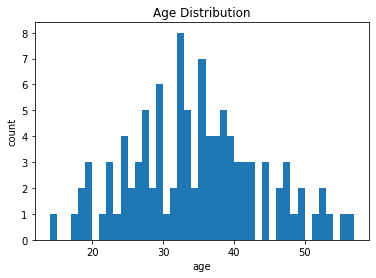

In [35]:
# show some stats on our passengers
# age distribution
age_range = max(df_passengers['age']) - min(df_passengers['age'])

# NOTE: children under the age of 2 may sit on laps
age_plot = plt.hist(list(df_passengers['age']), density=False, bins=age_range)
plt.xlabel('age')
plt.ylabel('count') 
plt.title('Age Distribution')
plt.show(age_plot)

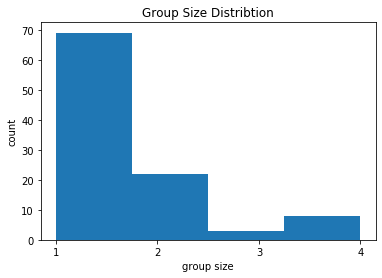

In [36]:
# show group sizes
max_group_size = max(df_passengers['group_size'])
group_size_plot = plt.hist(list(df_passengers['group_size']), density=False, bins=max_group_size)
plt.xlabel('group size')
# plt.set_xlim([1, max_group_size])
plt.xticks(list(range(1, max_group_size+1)))
plt.ylabel('count')
plt.title('Group Size Distribtion')
plt.show(group_size_plot)

In [37]:
print("Passenegers Previously Travelled: {}".format(df_passengers[df_passengers['has_travelled'] == True].count()['has_travelled']))

Passenegers Previously Travelled: 34


In [38]:
print("Passengers with Preexisting Conditions: {}".format(df_passengers[df_passengers['has_preexisting_condition'] == True].count()['has_preexisting_condition']))

Passengers with Preexisting Conditions: 15


In [39]:
# Lets resort the DataFrame to put Groups on Top and then Age descending for seating priority
df_passengers = df_passengers.sort_values(by=['group_size', 'age'], ascending=False)
df_passengers = df_passengers.reset_index(drop=True)
df_passengers['seat'] = 0
df_passengers['offset_order'] = 0
df_passengers['offset_x'] = 0
df_passengers['offset_y'] = 0
df_passengers['offset_method'] = 0


/opt/anaconda3/lib/python3.7/site-packages/pandas/core/ops/__init__.py:1115: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


BEST CASE Social Distance Offset: {'x': 2, 'y': 1, 'method': 'full_block'}
	Total Seats: 410
	Capacity: 20.5%
	Passengers Accommodated: 84
	Buffer Seats: 326
    A  B  C       D  E  F  G       H  J  K
43  P  +  +  | |  P  +  +  P  | |  +  +  P
44  +  +  +  | |  +  +  +  +  | |  +  +  +
45  P  +  +  | |  P  +  +  P  | |  +  +  P
46  +  +  +  | |  +  +  +  +  | |  +  +  +
47  P  +  +  | |  P  +  +  P  | |  +  +  P
48  +  +  +  | |  +  +  +  +  | |  +  +  +
49  P  +  +  | |  P  +  +  P  | |  +  +  P
50  +  +  +  | |  +  +  +  +  | |  +  +  +
51  P  +  +  | |  P  +  +  P  | |  +  +  P
52  +  +  +  | |  +  +  +  +  | |  +  +  +
53  P  +  +  | |  P  +  +  P  | |  +  +  P
54  +  +  +  | |  +  +  +  +  | |  +  +  +
55  P  +  +  | |  P  +  +  P  | |  +  +  P
56  +  +  +  | |  +  +  +  +  | |  +  +  +
57  P  +  +  | |  P  +  +  P  | |  +  +  P
58  +  +  +  | |  +  +  +  +  | |  +  +  +
59  P  +  +  | |  P  +  +  P  | |  +  +  P
60  +  +  +  | |  +  +  +  +  | |  +  +  +
61  P  +  +  | |  P  +  +

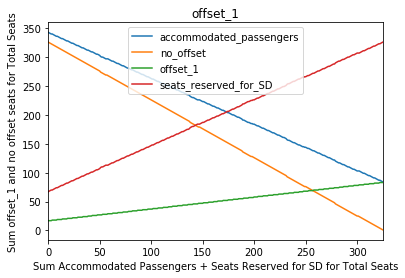

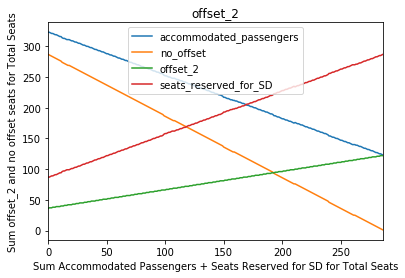

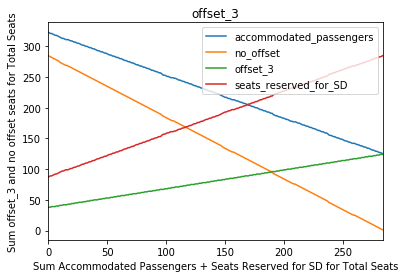

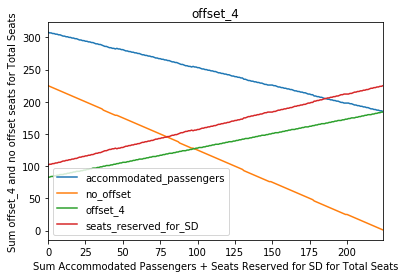

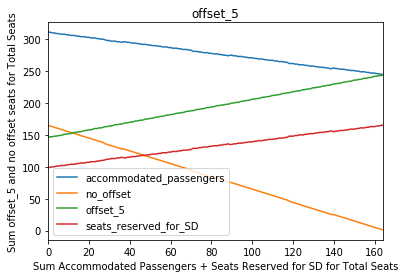

In [40]:
# Now Analyze the Offset Allowance we can use based on booked capacity of this flight and 5 options of 
# Social distancing compared to conventional seating with no distancing as default 

# Default x: 0 y: 0
no_offset = default_offset

# find offset theoretical limits
offset_1 = {'x': 2, 'y': 1, 'method': 'full_block'}
offset_2 = {'x': 2, 'y': 1, 'method': 'shaved_corners'}
# my_offset_2 = {'x': 2, 'y': 1, 'method': 'cardinal_only'} # doesn't really make sense
offset_3 = {'x': 1, 'y': 1, 'method': 'full_block'}
offset_4 = {'x': 1, 'y': 1, 'method': 'cardinal_only'}
offset_5 = {'x': 1, 'y': 0, 'method': 'cardinal_only'}



my_sd_offsets = [no_offset, offset_1, offset_2, offset_3, offset_4, offset_5]

# Run function to get offset info on plane model
offset_info = AnalyzeSocialDistance(my_plane, my_sd_offsets, view_charts=True)

# Add an order detail to offsets
my_attr = 'max_accommodation'
depth = 2
ascending = True
prioritize_dictionary_on_attribute(offset_info, my_attr, depth, ascending)


In [42]:
# FINALLY GET TO THE BOOKING!

my_plane.deplane()
# 1. SEAT ALL GROUPS

# 1a. FIND each group based on uuids in list
# 1b. SEND GROUP DATAFRAME to group AssignSeat

# in group_AssignSeat function:
# 2a. select offset 1 at a time
# 2b. Seat 1 at a time, and use seat state 'G' instead of 'P'
# 2c. Need to update SocialDistance block to understand 'G' is valid to have in SD block, but not to over-assign
# 2d. Recalculate Airplane buffer, remaining assignments, and free seats 

# 3a. Repeat until all group has been seated, add their Seat and offset to df passenger dataframe
# 3b. Repeat until all groups size > 1 seated (make sure seat states are always updated back to 'P' before
#      Moving on to next group)


# start breaking the passenger list down starting from largest groups to single passengers
max_group_size = max(df_passengers['group_size'])
for size in range(max_group_size, 1, -1):
    sub_df = df_passengers[df_passengers['group_size'] == size]

    if sub_df.empty:
        df_group = pd.DataFrame()
    
    elif len(sub_df) == size:
        df_group = sub_df
        
    else:
        df_group = pd.DataFrame()
        unique_groups = sub_df['group'].drop_duplicates().reset_index(drop=True)
        group_info = {}
        age_sum = 0
        more_flags = 0

        for grp in range(0, len(unique_groups)):        
            for row in sub_df.index:
                pID = sub_df['pID'][row]

                if pID in unique_groups[grp]:
                    age_sum += sub_df['age'][row]
                    precond = sub_df['has_preexisting_condition'][row]
                    if not precond:
                        more_flags += 1
                    hastravel = sub_df['has_travelled'][row]
                    if not hastravel:
                        more_flags += 1

            group_info.update({grp:{'age_sum':age_sum, 'false_flags':more_flags, 'pID_list': unique_groups[grp]}})

        prioritize_dictionary_on_attribute(group_info, 'false_flags', depth=2, ascending=True)
        for order, info in group_info.items():
            
            group = info['pID_list']            
            for row in sub_df.index:
                pID = sub_df['pID'][row]

                if pID in group:
                    this_line = sub_df[sub_df.index == row]   
                    df_group = pd.concat([df_group, this_line], axis=0)
                
    # Call group Assign Seat Function once df_group built
    if not df_group.empty:
        df_group = group_AssignSeat(my_plane, df_group, offset_info)

        # now update the main df_passenger dataframe with this information from each df_group
        for row in df_group.index:
            df_passengers.loc[row, :] = df_group.loc[row, :]





Total Seats: 410
Capacity: 25.0%
Booked Seats: 102
Remaining Seats to Assign: 100
Buffer Seats: 3
Free Seats: 305
Last Assigned Seat: 83B
Next Seat to Assign: 83C




Total Seats: 410
Capacity: 25.0%
Booked Seats: 102
Remaining Seats to Assign: 99
Buffer Seats: 3
Free Seats: 305
Last Assigned Seat: 83C
Next Seat to Assign: 82A








Total Seats: 410
Capacity: 25.0%
Booked Seats: 102
Remaining Seats to Assign: 96
Buffer Seats: 5
Free Seats: 303
Last Assigned Seat: 82C
Next Seat to Assign: 81A




Total Seats: 410
Capacity: 25.0%
Booked Seats: 102
Remaining Seats to Assign: 95
Buffer Seats: 6
Free Seats: 302
Last Assigned Seat: 81A
Next Seat to Assign: 81B




Total Seats: 410
Capacity: 25.0%
Booked Seats: 102
Remaining Seats to Assign: 94
Buffer Seats: 7
Free Seats: 301
Last Assigned Seat: 81B
Next Seat to Assign: 83K




Total Seats: 410
Capacity: 25.0%
Booked Seats: 102
Remaining Seats to Assign: 93
Buffer Seats: 11
Free Seats: 297
Last Assigned Seat: 83K
Next Seat to Assign: 82

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s




Total Seats: 410
Capacity: 25.0%
Booked Seats: 102
Remaining Seats to Assign: 91
Buffer Seats: 14
Free Seats: 294
Last Assigned Seat: 82J
Next Seat to Assign: 83G




Total Seats: 410
Capacity: 25.0%
Booked Seats: 102
Remaining Seats to Assign: 90
Buffer Seats: 16
Free Seats: 292
Last Assigned Seat: 83G
Next Seat to Assign: 82D






Total Seats: 410
Capacity: 25.0%
Booked Seats: 102
Remaining Seats to Assign: 88
Buffer Seats: 18
Free Seats: 290
Last Assigned Seat: 82F
Next Seat to Assign: 82G






Total Seats: 410
Capacity: 25.0%
Booked Seats: 102
Remaining Seats to Assign: 86
Buffer Seats: 27
Free Seats: 281
Last Assigned Seat: 79H
Next Seat to Assign: 79J




Total Seats: 410
Capacity: 25.0%
Booked Seats: 102
Remaining Seats to Assign: 85
Buffer Seats: 26
Free Seats: 282
Last Assigned Seat: 79J
Next Seat to Assign: 79K




Total Seats: 410
Capacity: 25.0%
Booked Seats: 102
Remaining Seats to Assign: 84
Buffer Seats: 25
Free Seats: 283
Last Assigned Seat: 79K
Next Seat to Assign: 

In [44]:
# VIEWING IN JUPYTER


# FIX 1: Change check seat state 'G' and 'P' when building block
# FIX 2" find open seat jumps around too
my_plane.view_plane()
df_passengers[df_passengers['group_size'] > 1]

Total Seats: 410
Capacity: 25.0%
Booked Seats: 102
Remaining Seats to Assign: 69
Buffer Seats: 30
Free Seats: 278
Last Assigned Seat: 74K
Next Seat to Assign: 80D


    A  B  C       D  E  F  G       H  J  K
43  0  0  0  | |  0  0  0  0  | |  0  0  0
44  0  0  0  | |  0  0  0  0  | |  0  0  0
45  0  0  0  | |  0  0  0  0  | |  0  0  0
46  0  0  0  | |  0  0  0  0  | |  0  0  0
47  0  0  0  | |  0  0  0  0  | |  0  0  0
48  0  0  0  | |  0  0  0  0  | |  0  0  0
49  0  0  0  | |  0  0  0  0  | |  0  0  0
50  0  0  0  | |  0  0  0  0  | |  0  0  0
51  0  0  0  | |  0  0  0  0  | |  0  0  0
52  0  0  0  | |  0  0  0  0  | |  0  0  0
53  0  0  0  | |  0  0  0  0  | |  0  0  0
54  0  0  0  | |  0  0  0  0  | |  0  0  0
55  0  0  0  | |  0  0  0  0  | |  0  0  0
56  0  0  0  | |  0  0  0  0  | |  0  0  0
57  0  0  0  | |  0  0  0  0  | |  0  0  0
58  0  0  0  | |  0  0  0  0  | |  0  0  0
59  0  0  0  | |  0  0  0  0  | |  0  0  0
60  0  0  0  | |  0  0  0  0  | |  0  0  0
61  0  0  0  | |  

,pID,age,group_size,group,has_travelled,has_preexisting_condition,seat,offset_order,offset_x,offset_y,offset_method
0,99e7d17b-154f-4e78-841b-39f98f1b3c5d,57,4,"[99e7d17b-154f-4e78-841b-39f98f1b3c5d, 95615ce...",False,True,83A,1,2,1,full_block
1,01d17ebd-34f6-4abc-a688-397d04eb3fdb,48,4,"[d6e5d4cf-38de-41cd-b780-5f3bdc4dfe78, fd7bbd4...",False,True,82B,1,2,1,full_block
2,4a956528-e3c8-4365-ac0e-0527ca0a1eb1,47,4,"[99e7d17b-154f-4e78-841b-39f98f1b3c5d, 95615ce...",False,True,83B,1,2,1,full_block
3,fd7bbd4c-178a-402e-8944-e32fbffe3914,47,4,"[d6e5d4cf-38de-41cd-b780-5f3bdc4dfe78, fd7bbd4...",True,True,82C,1,2,1,full_block
4,95615cec-e086-4ce7-8096-4809ea205cad,37,4,"[99e7d17b-154f-4e78-841b-39f98f1b3c5d, 95615ce...",False,False,83C,2,2,1,shaved_corners
5,fc2f5884-0e64-427a-b2fd-8f246bf990f1,33,4,"[99e7d17b-154f-4e78-841b-39f98f1b3c5d, 95615ce...",False,False,82A,2,2,1,shaved_corners
6,d6e5d4cf-38de-41cd-b780-5f3bdc4dfe78,28,4,"[d6e5d4cf-38de-41cd-b780-5f3bdc4dfe78, fd7bbd4...",False,False,81A,2,2,1,shaved_corners
7,7875b797-7d13-4344-8883-ed6943d8b0ab,24,4,"[d6e5d4cf-38de-41cd-b780-5f3bdc4dfe78, fd7bbd4...",False,False,81B,2,2,1,shaved_corners
8,de896f39-8d71-48ac-b381-de945d8f81e4,49,3,"[a85fcf23-8ef0-4eb7-9e44-83fb0166efb9, de896f3...",False,False,83K,2,2,1,shaved_corners
9,a85fcf23-8ef0-4eb7-9e44-83fb0166efb9,40,3,"[a85fcf23-8ef0-4eb7-9e44-83fb0166efb9, de896f3...",False,False,82H,2,2,1,shaved_corners


In [ ]:
# finish with all single fliers
sub_df = df_passengers[df_passengers['group_size']==1]

In [ ]:
sub_df = single_AssignSeat(my_plane, sub_df, offset_info)

In [ ]:
my_plane.view_plane()
sub_df[sub_df['seat'] == 0]

In [ ]:
for row in sub_df.index:
    df_passengers.loc[row, :] = sub_df.loc[row, :]